# Simulating capillary pressure curves using Porosimetry

Start by importing OpenPNM and checking the version to be sure you're using the same version as this example.

In [1]:
import openpnm as op
print(op.__version__)

2.1.0


Next, create a simple cubic network with 20 pores per side and a spacing of 50 um

In [2]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=0.00005)

The network object only contains topological and spatial information.  We need to assign some pore and throat sizes, which can be conveniently done by creating a ``StickAndBall`` geometry object.

In [3]:
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

The ``StickAndBall`` class assigns pores as random values between 0.2 and 0.7 of the lattice spacing, then finds all other geometric information assuming the pores are spheres and the throats are cylinders.

Next we need to create a phase object which contains the thermo-physical properties of the invading fluid, such as surface tension:

In [4]:
hg = op.phases.Mercury(network=pn, name='mercury')

Lastly, we need to compute the capillary entry pressure of the throats in the network.  The OpenPNM ``models`` library has a few common capillary pressure models, including the Washburn equation:

$$ P_C = \frac{-2\sigma cos(\theta)}{R_T} $$

To use this model we should create a physics object, and use the ``add_model`` method as follows:

In [5]:
phys = op.physics.GenericPhysics(network=pn, phase=hg, geometry=geo)
phys.add_model(propname='throat.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn)

Note that we can inspect our ``project`` to see the interrelationships between all the object with:

In [6]:
print(pn.project.grid)

┌Project: sim_01───────────┐
│   net_01   │   mercury   │
├────────────┼─────────────┤
│   geo_01   │   phys_01   │
└────────────┴─────────────┘


The ``grid`` shows us that 'phys_01' is associated with the 'mercury' phase, and 'geo_01'.  This means that when calculating the throat entry pressure using the Washburn equation above, it will fetch the throat radius ($R_T$) from 'geo_01' and the surface tension and contact angle from 'mercury'.

Now that all the required objects are setup, we can perform the capillary pressure curve simulation.  OpenPNM contains both InvasionPercolation and OrdinaryPercolation classes.  The porosimetry experiment is ordinary percolation with access limitations.  This means that a fixed pressure is applied to the invading fluid and all pores and throat that can be penetrated at that pressure are set as *possibly* invaded, *then* pores and throats are set to invaded only if they are physically connected to the source of invading fluid directly or though a path of already invading pores and throats.  Since this process is simulated very frequently, OpenPNM includes a class called Porosimetry that is a subclass of OrdinaryPercolation, with several useful methods added.  It's use is illustrated below:

In [7]:
mip = op.algorithms.Porosimetry(network=pn, phase=hg)
mip.set_inlets(pores=pn.pores('left'))
mip.run()

The meaning of this warning message will be analyzed below, but first let's take a quick look at the result using the built-in plotting method:

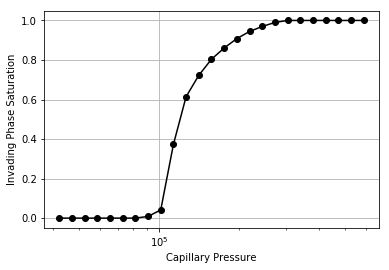

In [8]:
fig = mip.plot_intrusion_curve()

In [9]:
Pc, Snwp = mip.get_intrusion_data()
print(Pc, Snwp)

[ 42171.02410098  47062.12251602  52520.50247605  58611.95868073
  65409.91685976  72996.31883839  81462.61025496  90910.84283639
 101454.90451822 113221.89223706 126353.64394274 141008.44829709
 157362.95266771 175614.29241549 195982.46714216 218712.9925408
 244079.85981448 272388.83833544 303981.16135482 339237.63919003
 378583.24946951 422492.25976545 471493.94436188 526178.9640675
 587206.48597483] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008492322347110497, 0.04142165490143637, 0.3731080029146732, 0.6144086886493323, 0.7223169525602933, 0.8036599837265193, 0.8606716417026047, 0.9080230270502405, 0.9441441601457407, 0.9694293170848679, 0.9897893388022185, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


With the above data in the form of arrays it's possible to cut&paste into Excel, or to use a Python plotting package such as Matplotlib to make plots with your desired style:

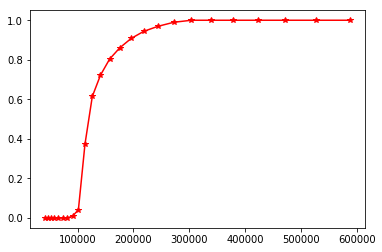

In [10]:
import matplotlib.pyplot as plt
fig = plt.plot(Pc, Snwp, 'r*-')